# Fine-tuning an Object Detection Model

In this tutorial we are going to use transfer-learning to fine-tune a pre-trained object detection model and train it to detect faces

## Building a Face Detector


In [1]:
import glob
import math
import os
from os.path import join
import random
import tarfile
import time

import cv2
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import autograd, gluon
import numpy as np
from gluoncv.utils import download, viz
import gluoncv as gcv

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 10

# Data

We use the [FDDB dataset](http://vis-www.cs.umass.edu/fddb/) 
A data set of face regions designed for studying the problem of unconstrained face detection. This data set contains the annotations for 5171 faces in a set of 2845 images taken from the Faces in the Wild data set. More details can be found in the technical report below. 

download and extract the data

In [3]:
data_dir = 'support/fddb'
if not os.path.isdir(data_dir):
    archive_path = mx.test_utils.download('https://mxnet-workshop-dropbox.s3-us-west-2.amazonaws.com/fddb-images.tar.gz', dirname='support')
    tar = tarfile.open(archive_path)
    tar.extractall(data_dir)
    tar.close()
    os.remove(archive_path)

### Dataset images

In [4]:
images = glob.glob(join(data_dir, 'images/**/**/**/**/*.jpg'))

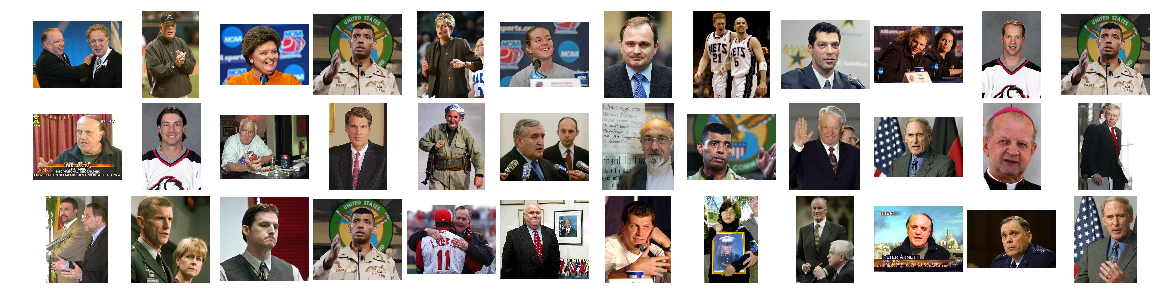

In [5]:
n_images = 36
cols = (int(math.sqrt(n_images)))*2
fig = plt.figure(figsize=(20,5))
for n, (image) in enumerate(images[:n_images]):
    image = plt.imread(image)
    a = fig.add_subplot(np.ceil(n_images/float(cols)), cols, n + 1)
    plt.imshow(image)
    plt.axis('off')
plt.subplots_adjust(wspace=0.06, hspace=0.06)
plt.show()

### Dataset annotation

Let's explore how the annotations are given to us for the images

In [6]:
annotations_text = open(join(data_dir, 'FDDB-annotations.txt'), 'r').readlines()
info = annotations_text[0][:-1].split(',')
info[1:] = [float(e) for e in info[1:]]
info

['images/2002/08/11/big/img_591.jpg',
 180.05081677994312,
 41.13396106443558,
 359.33598322005685,
 282.42843893556443]

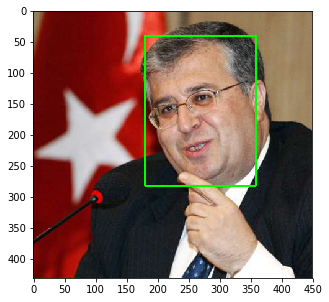

In [7]:
img = plt.imread(join(data_dir,info[0]))
img = cv2.rectangle(img, (int(info[1]), int(info[2])),(int(info[3]), int(info[4])), (0,255,0), 2)
plt.imshow(img)

### MXNet Gluon Dataset

Great! Now we can move to creating a data iterator that MXNet will use to serve the data during training

We create a custom dataset that reads the files

In [8]:
FACE_CLASS = 0

class FDDBDataset(gluon.data.Dataset):
    
    def __init__(self, annotation_file='FDDB-annotations.txt', split='train', data_path='support/fddb/'):

        assert split in ['train', 'test', 'val'], "Wrong value for split"

        self.files_data = {}
        self.files = []
        with open(join(data_path, annotation_file)) as f:
            for line in f.read().splitlines():
                elem = line.split(',')
                path = join(data_path, elem[0])
                if path not in self.files:
                    self.files.append(path)
                    self.files_data[path] = [[float(e) for e in [elem[1],elem[2],elem[3],elem[4], FACE_CLASS]]]
                else:
                    self.files_data[path].append([float(e) for e in [elem[1],elem[2],elem[3],elem[4], FACE_CLASS]])
                
        # Splitting the sets
        l = len(self.files)
        test_split = 0.8
        val_split = 0.9
        splits = {'train':[0,int(test_split*l)],'test':[int(test_split*l),int(val_split*l)],'val':[int(val_split*l),l]}
        
        self.files = self.files[splits[split][0]:splits[split][1]]
        
        
    def __getitem__(self, idx):
        file = self.files[idx]
        return mx.image.imread(file), np.array(self.files_data[file])
        
    def __len__(self):
        return len(self.files)

In [9]:
classes = ['face']
train_dataset = FDDBDataset(split='train')
test_dataset = FDDBDataset(split='test')
val_dataset = FDDBDataset(split='val')

Now that we have created the datasets and returning the data in the GluonCV way, we can take care of the visualization tool to easily visualize the data

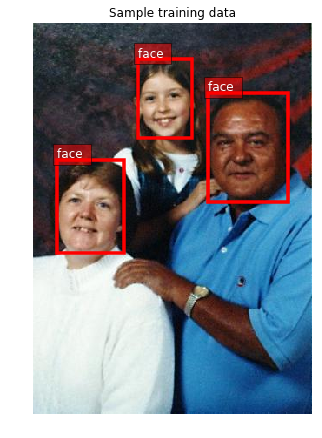

In [10]:
image, label = train_dataset[123]
ax = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5], class_names=classes)
plt.axis('off')
plt.title('Sample training data')
plt.show()

# Network

In [11]:
batch_size = 32
ctx = [mx.gpu(0)] if mx.context.num_gpus() > 0 else [mx.cpu()]

We choose mobilenet backend for the SSD model, this is a fast-to-train and relatively accurate model that will serve us well for this demo

![](https://cdn-images-1.medium.com/max/1200/1*pPxrkm4Urz04Ez65mwWE9Q.png)

*source: [SSD: Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325), Wei Liu, Dragomir Anguelov, Dumitru Erhan, Christian Szegedy, Scott Reed, Cheng-Yang Fu, Alexander C. Berg, 2015*

We get the pre-trained model from the model-zoo

In [70]:
model_name = 'mobilenet1.0' 
net = gcv.model_zoo.get_model('ssd_512_{}_voc'.format(model_name), pretrained=True, ctx=ctx)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/mxnet/gluon/block.py:1146: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


Let's test it on a random image

100%|██████████| 535/535 [00:00<00:00, 9468.03KB/s]

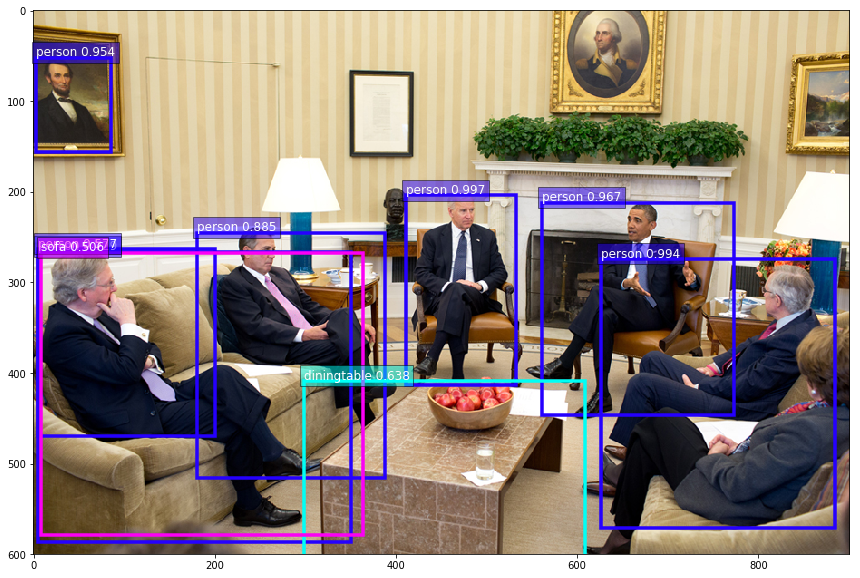

In [71]:
def test_picture(net, url, min_size=512, max_size=1024):
    f = download(url, 'test.jpg', overwrite=True)
    x, image = gcv.data.transforms.presets.ssd.load_test('test.jpg', min_size, max_size)
    cid, score, bbox = net(x.as_in_context(ctx[0]))
    ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=net.classes)
    ax.figure.set_figheight(10)
    ax.figure.set_figwidth(15)
    plt.show()

test_picture(net, 'https://obamawhitehouse.archives.gov/sites/default/files/image/2012_photos/81.jpeg.jpg', min_size=600)

Clearly, we are not detecting the faces and we are getting swamped with a lot of different classes

#### fine-tuning for faces 

In [72]:
net.reset_class(classes)

image_size = 512

#### Data iterators

In [13]:
from gluoncv.data.batchify import Tuple, Stack, Pad
from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform, SSDDefaultValTransform
from gluoncv.utils.metrics.voc_detection import VOC07MApMetric

num_workers = 8

# This is a special mode in the network to get the anchors
# So that we can precompute the deltas between anchors and
# ground truth ahead of time during in the dataset transform
with autograd.train_mode():
    _, _, anchors = net(mx.nd.zeros((1, 3, image_size, image_size)))
train_transform = SSDDefaultTrainTransform(image_size, image_size, anchors)
batchify_fn = Tuple(Stack(), Stack(), Stack())  # stack image, cls_targets, box_targets
train_data = gluon.data.DataLoader(train_dataset.transform(train_transform), batch_size, True, batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)

In [14]:
val_transform = SSDDefaultValTransform(image_size, image_size)
batchify_fn = Tuple(Stack(), Pad(pad_val=-1))
val_data = gluon.data.DataLoader(val_dataset.transform(val_transform), batch_size, False, batchify_fn=batchify_fn, last_batch='keep', num_workers=num_workers)

test_transform = SSDDefaultValTransform(image_size, image_size)
batchify_fn = Tuple(Stack(), Pad(pad_val=-1))
test_data = gluon.data.DataLoader(test_dataset.transform(val_transform), 8, False, batchify_fn=batchify_fn, last_batch='keep', num_workers=num_workers)

## Evaluation

In [15]:
def validate(net, val_data, ctx, classes, size):
    """
    Compute the mAP for the network on the validation data
    """
    metric = VOC07MApMetric(iou_thresh=0.5, class_names=classes)
    net.set_nms(0.45)
    for ib, batch in enumerate(val_data):
        
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        det_bboxes, det_ids, det_scores = [],[],[]
        gt_bboxes,gt_ids = [], []
        
        for x, y in zip(data, label):
            ids, scores, bboxes = net(x)
            det_ids.append(ids)
            det_scores.append(scores)
            det_bboxes.append(bboxes.clip(0, batch[0].shape[2]))
            gt_ids.append(y.slice_axis(axis=-1, begin=4, end=5))
            gt_bboxes.append(y.slice_axis(axis=-1, begin=0, end=4))
            
            metric.update(det_bboxes, det_ids, det_scores, gt_bboxes, gt_ids, [None])
    return metric.get()

# Training

#### Training hyper-parameters:

In [14]:
num_epochs = 5

In [15]:
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(
    net.collect_params(), 'sgd',
    {'learning_rate': 0.001, 'wd': 0.0005, 'momentum': 0.9})

learning rate

In [16]:
steps_epochs = [3, 4]
iterations_per_epoch = math.ceil(len(train_dataset) / batch_size)
steps_iterations = [s*iterations_per_epoch for s in steps_epochs]
print("Learning rate drops after iterations: {}".format(steps_iterations))
schedule = mx.lr_scheduler.MultiFactorScheduler(step=steps_iterations, factor=0.33)

Learning rate drops after iterations: [213, 284]


The object detection tasks combines losses for box localization and class detection

In [17]:
mbox_loss = gcv.loss.SSDMultiBoxLoss()
ce_metric = mx.metric.Loss('CrossEntropy')
smoothl1_metric = mx.metric.Loss('SmoothL1')

net.hybridize(static_alloc=True, static_shape=True)

#### Main training loop

In [18]:
best_val = 0 
net.set_nms(0.45)
for epoch in range(num_epochs):
    net.hybridize(static_alloc=True, static_shape=True)
    ce_metric.reset()
    smoothl1_metric.reset()
    tic, btic = time.time(), time.time()

    for i, batch in enumerate(train_data):

        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        cls_targets = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        box_targets = gluon.utils.split_and_load(batch[2], ctx_list=ctx, batch_axis=0)

        with autograd.record():
            cls_preds, box_preds = [], []
            for x in data:
                cls_pred, box_pred, _ = net(x)
                cls_preds.append(cls_pred)
                box_preds.append(box_pred)
            sum_loss, cls_loss, box_loss = mbox_loss(cls_preds, box_preds, cls_targets, box_targets)
            autograd.backward(sum_loss)

        trainer.step(1)
        ce_metric.update(0, [l * batch_size for l in cls_loss])
        smoothl1_metric.update(0, [l * batch_size for l in box_loss])
        name1, loss1 = ce_metric.get()
        name2, loss2 = smoothl1_metric.get()

        if i % 20 == 0:
            print('[Epoch {}][Batch {}], Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}'.format(epoch, i, batch_size/(time.time()-btic), name1, loss1, name2, loss2))
        btic = time.time()
        
    name, val = validate(net, val_data, ctx, classes, image_size)
    
    print('[Epoch {}] Training cost: {:.3f}, Learning rate {}, mAP={:.3f}'.format(epoch, (time.time()-tic), trainer.learning_rate, val[0]))
    
    # If validation accuracy improve, save the parameters
    if val[0] > best_val:
        net.save_parameters('support/ssd_{}.face.params'.format(model_name))
        best_val = val[0]
        print("Saving the parameters, best mAP {}".format(best_val))


[Epoch 0][Batch 0], Speed: 4.232 samples/sec, CrossEntropy=7.235, SmoothL1=2.048
[Epoch 0][Batch 20], Speed: 149.771 samples/sec, CrossEntropy=3.736, SmoothL1=1.219
[Epoch 0][Batch 40], Speed: 152.359 samples/sec, CrossEntropy=3.032, SmoothL1=1.012
[Epoch 0][Batch 60], Speed: 157.766 samples/sec, CrossEntropy=2.674, SmoothL1=0.875
[Epoch 0] Training cost: 28.928, Learning rate 0.001, mAP=0.889
Saving the parameters, best mAP 0.8892778506264458
[Epoch 1][Batch 0], Speed: 16.500 samples/sec, CrossEntropy=1.798, SmoothL1=0.728
[Epoch 1][Batch 20], Speed: 154.277 samples/sec, CrossEntropy=1.750, SmoothL1=0.556
[Epoch 1][Batch 40], Speed: 154.870 samples/sec, CrossEntropy=1.712, SmoothL1=0.559
[Epoch 1][Batch 60], Speed: 157.935 samples/sec, CrossEntropy=1.670, SmoothL1=0.538
[Epoch 1] Training cost: 17.540, Learning rate 0.001, mAP=0.903
Saving the parameters, best mAP 0.9032700836272266
[Epoch 2][Batch 0], Speed: 17.128 samples/sec, CrossEntropy=1.455, SmoothL1=0.344
[Epoch 2][Batch 20], 

## Testing the Face Detection model

Let's test our model on some examples of the test dataset

In [74]:
net.collect_params().reset_ctx(ctx)
net.load_parameters('support/ssd_{}.face.params'.format(model_name), ctx=ctx)

In [24]:
# We create functions to unnormalize the normalized data by doing the inverse normalization
unnormalize_1 = gluon.data.vision.transforms.Normalize(std=(1/0.229, 1/0.224, 1/0.225))
unnormalize_2 = gluon.data.vision.transforms.Normalize(mean=(-0.485, -0.456, -0.406))

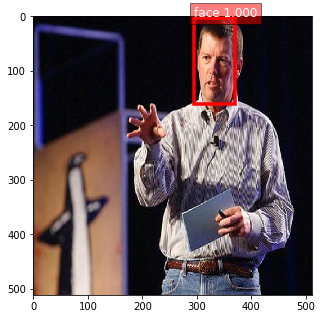

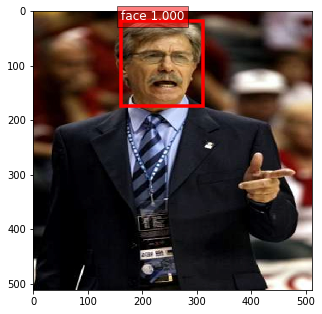

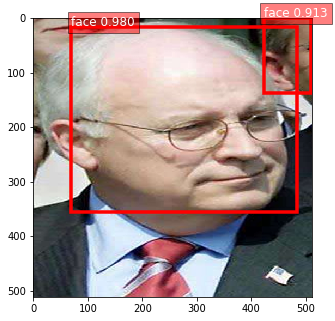

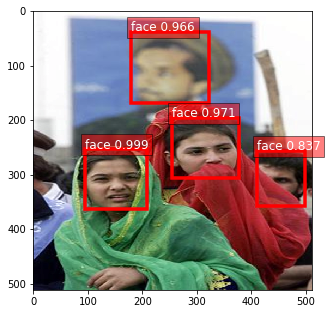

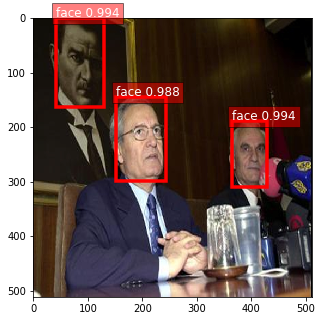

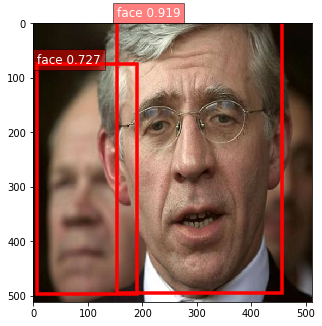

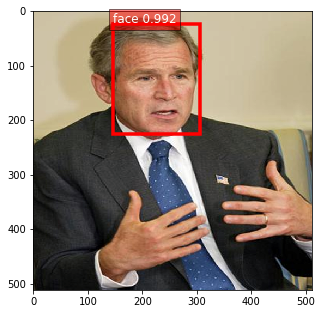

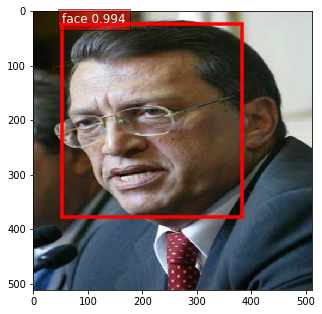

In [25]:
net.set_nms(0.45)
for (data, _) in test_data:
    ids, scores, bboxes = net(data.as_in_context(ctx[0]))
    for cid, score, bbox, image in zip(ids, scores, bboxes, data):
        image = (unnormalize_2(unnormalize_1(image)).transpose((1,2,0))*255).astype('uint8')
        ax = viz.plot_bbox(image.asnumpy(), bbox, score, cid, class_names=classes)
        plt.show()
    break

Let's compare with our original picture

100%|██████████| 535/535 [00:00<00:00, 9377.47KB/s]

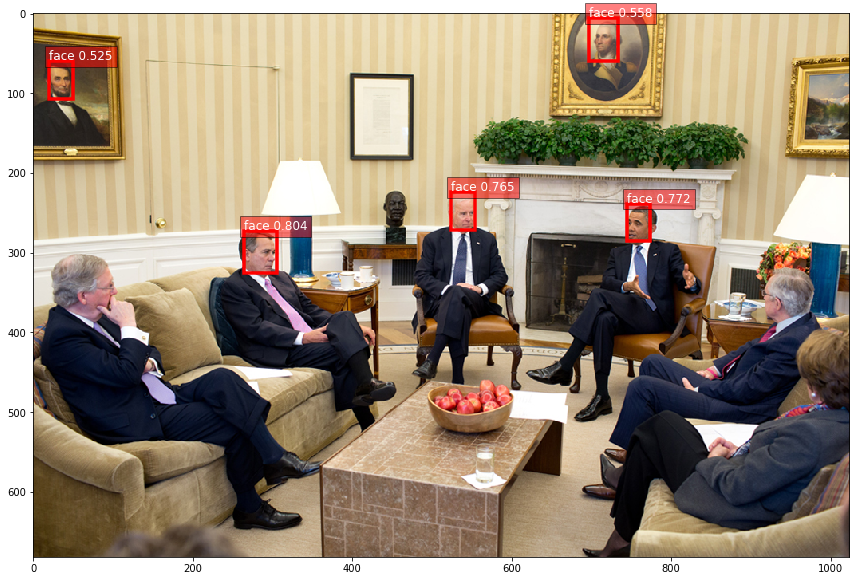

In [75]:
test_picture(net, 'https://obamawhitehouse.archives.gov/sites/default/files/image/2012_photos/81.jpeg.jpg', min_size=800)

Let's test our face detection model on new images!

159KB [00:00, 2473.15KB/s]             

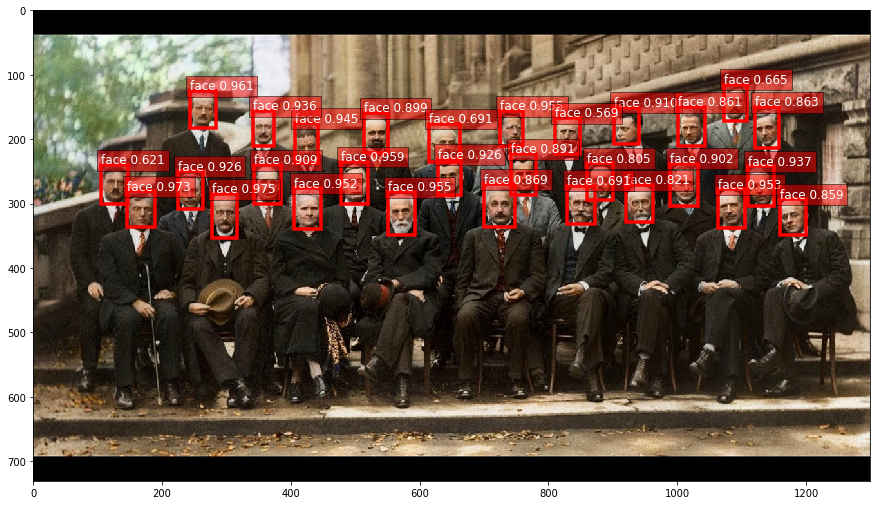

In [79]:
test_picture(net, 'https://i.ytimg.com/vi/jOFiETncmZM/maxresdefault.jpg', 800, 1300)

We have successfully fine-tuned an object detection network to only detect object we care about, in this case faces!